In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker
import h5py as h5

In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
data_path = path_prefix + "v7/"
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
ext_datapath = 'H:/EPE_file_storage/data_storage/pipm/root/clusters/'
ext_plotpath = ext_path + "plots/"

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [4]:
# load training data
with h5.File(ext_datapath+'single_cluster_only_normalized.h5', 'r') as hf:
    X = hf['X'][300000:]
    Y = hf['Y'][300000:]


In [5]:
X.shape

(53782, 939, 5)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model, model_from_json
import keras.backend as Kb

In [7]:
import scipy.stats as stats

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1),
                   x_step=0.05, 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, x_step)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

In [8]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

In [9]:
def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))
## Basic PFN
def PFN_base(num_features, name="PFN_Network"):

    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('linear', name="activation_6")(dense_6)
    #=========================================================================#
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

In [56]:
model = PFN_base(5)
model.load_weights("model/pfn_cluster_only.h5")
preds = np.exp(model.predict(eval_generator(X,500)).flatten())
print(preds.shape)

(53782,)


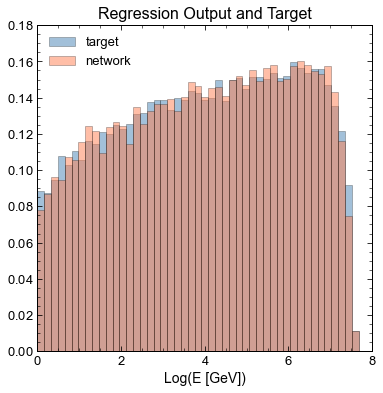

In [30]:
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(Y, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(np.log(preds), color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(-0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

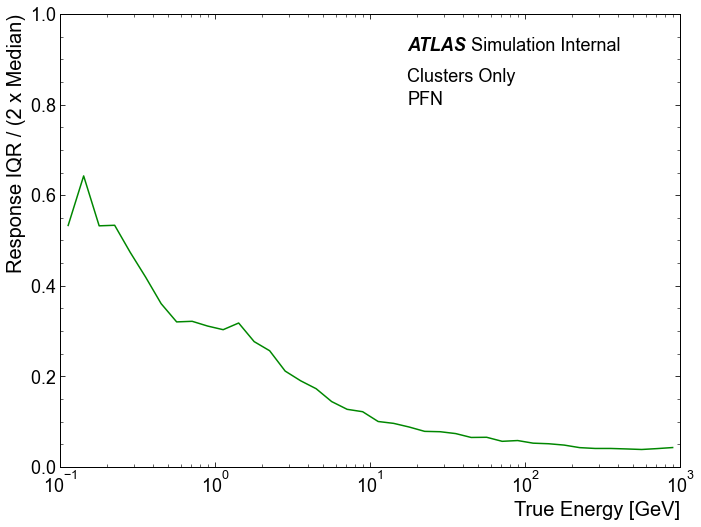

In [57]:
xcenter, PFN_5f = resolutionPlot(np.exp(Y), preds/np.exp(Y),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True, x_step=0.1,
                        xlim=(0.1,1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])

<Figure size 799.992x599.976 with 0 Axes>

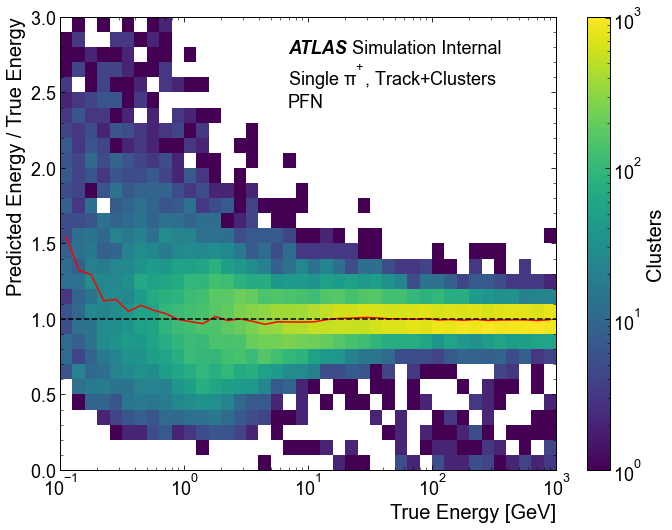

In [32]:
xcenter, med_PFN_5f, std = ru.responsePlot(np.exp(Y), y=preds/np.exp(Y),
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 step=0.1,
                 xlim = (0.1, 1000),
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track+Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'PFN'}])

In [20]:
import tensorflow_probability as tfp

def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))

def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def ParticleFlow_MDN(num_features, name="PFN_MDN_Network"):
    
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.))(activation_5)

    
    mdn_0 = tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor)(dense_6)
    
    return keras.Model(inputs=inputs, outputs=mdn_0, name=name)

In [21]:
PFN_mdn = ParticleFlow_MDN(num_features=5)

In [22]:
PFN_mdn.summary()

Model: "PFN_MDN_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, None, 100)    0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, None, 100)    10100       activation_0[0][0]               
____________________________________________________________________________________

In [33]:
PFN_mdn.load_weights('model\PFN_MDN_CL.h5')
preds = PFN_mdn.predict(eval_generator(X,500))
print(preds.shape)

(53782, 2)


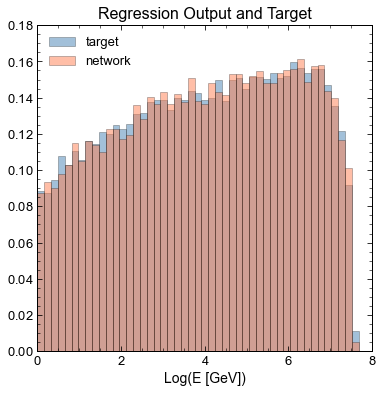

In [34]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(Y, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds[:,0], color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

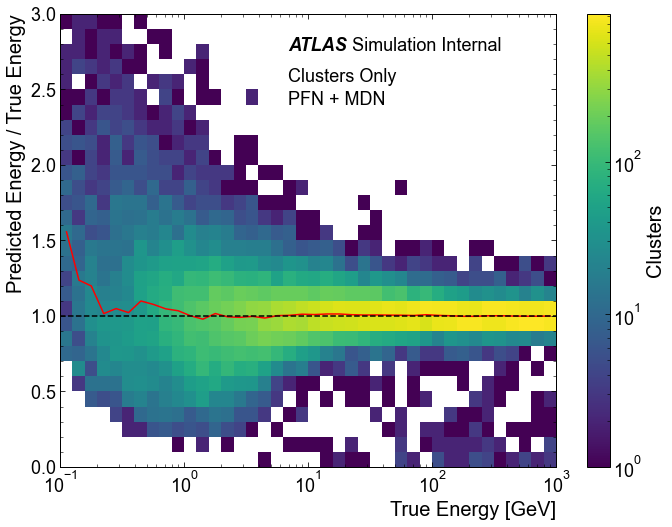

In [54]:
xcenter, medPFNMDN, std = ru.responsePlot(x=np.exp(Y), y=np.exp(preds[:,0])/np.exp(Y),
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True, step=0.1,
                 xlim = (0.1, 1000),
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Clusters Only'},
                             {'x': 0.46, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

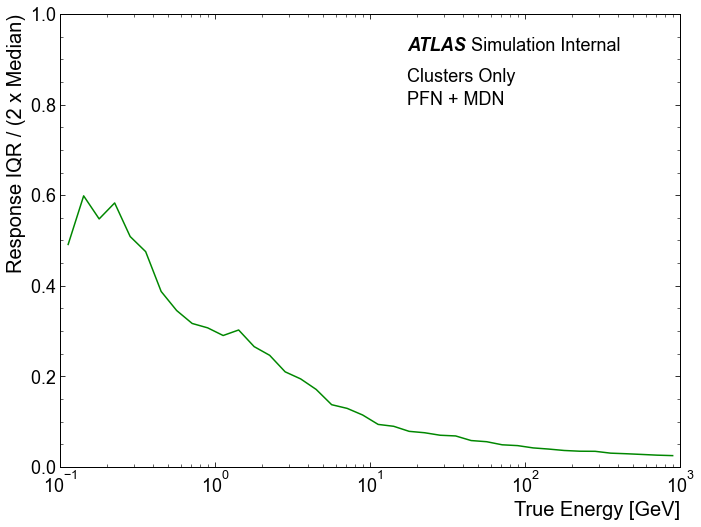

In [53]:
xcenter, iqrPFNMDN = resolutionPlot(x=np.exp(Y), y=np.exp(preds[:,0])/np.exp(Y),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        x_step=0.1,
                        xlim = (0.1, 1000),
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Clusters Only'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

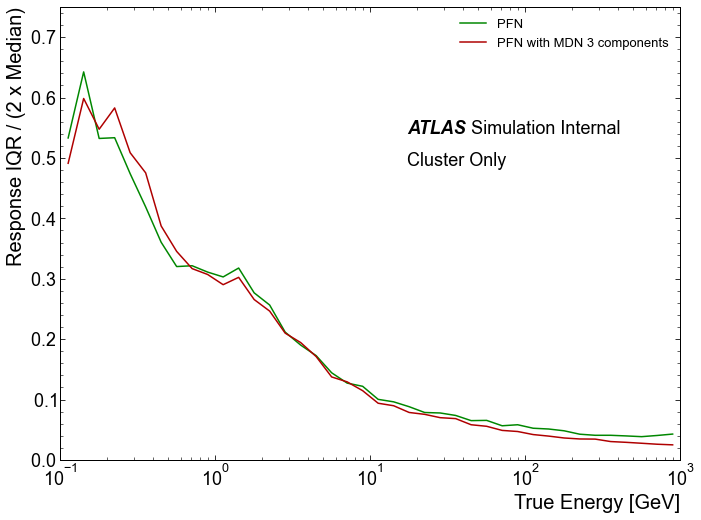

In [51]:
pu.lineOverlay(xcenter=xcenter, lines = [PFN_5f, iqrPFNMDN],
                labels = ['PFN', 'PFN with MDN 3 components'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.1, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Cluster Only'}])

In [37]:
_median = preds[:,0]
median = np.exp(_median)
sigma = preds[:,1]*median

# Calculate pull
pull = (median-np.exp(Y)) / sigma
badval_mask = np.logical_and(pull < 100, pull > -100)
pull = pull[badval_mask]

In [38]:
median_over_true = median / np.exp(Y)   #   Reconstructed Energy / True Energy --- Resolution
iqr_over_median = 2 * sigma / median  # Reconstructed Energy Resolution Per Cluster --- Predicted Energy Resolution vs predicted energy -- predict resolution
iqr_over_true = 2 * sigma / np.exp(Y)  # Pred Sigma / True Energy Per Cluster

<Figure size 799.992x599.976 with 0 Axes>

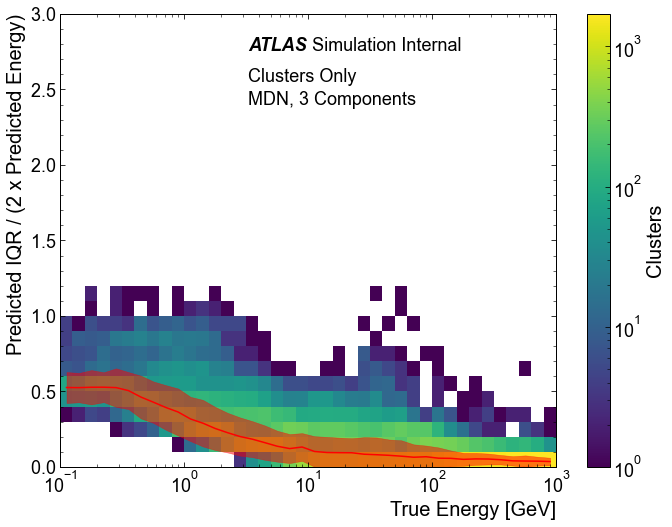

In [50]:
xcenter, iqrOverMed_MDN_learned, learned_error = ru.responsePlot(np.exp(Y), iqr_over_median/2,
                 'mean',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.1,1000), ylim=(0,3), baseline=False, fill_error=True,
                 step=0.1,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Clusters Only'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN, 3 Components'}])


In [40]:
upper = iqrOverMed_MDN_learned-learned_error
lower = iqrOverMed_MDN_learned+learned_error

(0.0, 0.7)

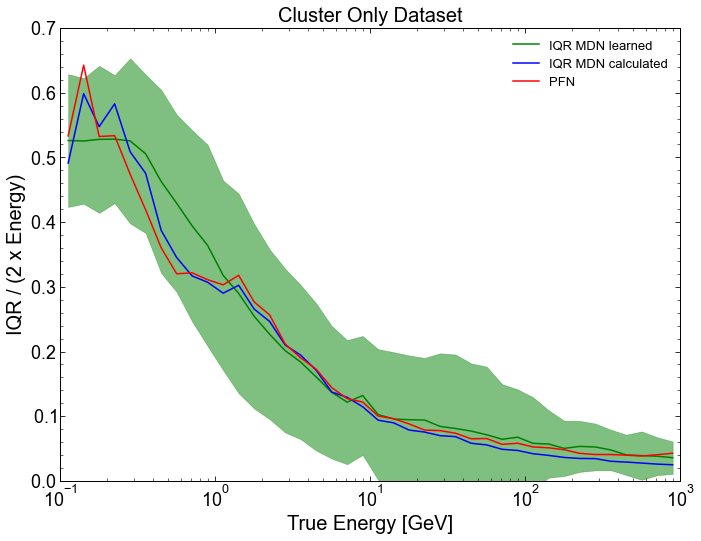

In [43]:
plt.plot(xcenter, iqrOverMed_MDN_learned, label='IQR MDN learned', color='green')
#plt.errorbar(xcenter, iqrOverMed_MDN_learned, yerr=learned_error, label='IQR MDN learned')
plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')
plt.plot(xcenter, iqrPFNMDN, 'b', label='IQR MDN calculated')
plt.plot(xcenter, PFN_5f, 'r',label='PFN')
#plt.plot(xcenter, PFN_5f, 'b-', label='IQR PFN')
plt.title('Cluster Only Dataset')
plt.xlabel('True Energy [GeV]')
plt.ylabel('IQR / (2 x Energy)')
plt.legend()
plt.xscale('log')
plt.xlim(0.1,1000)
plt.ylim(0,0.7)

<Figure size 799.992x599.976 with 0 Axes>

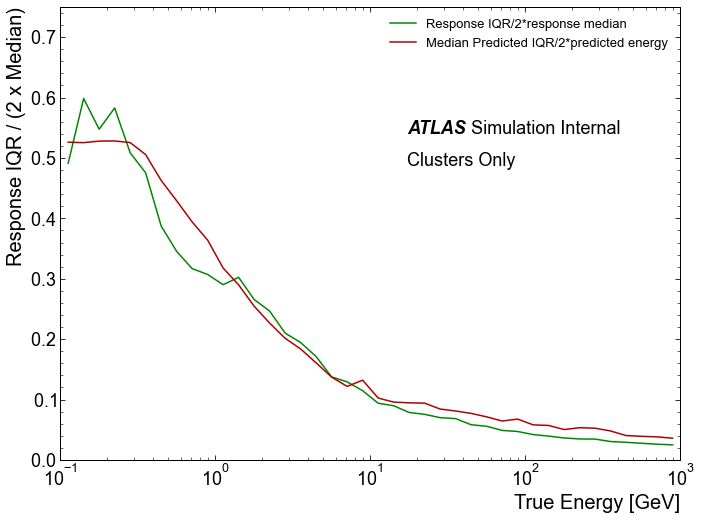

In [48]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrPFNMDN, iqrOverMed_MDN_learned],
                labels = ['Response IQR/2*response median', 'Median Predicted IQR/2*predicted energy','upper','lower'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.1, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Clusters Only'}])

<Figure size 799.992x599.976 with 0 Axes>

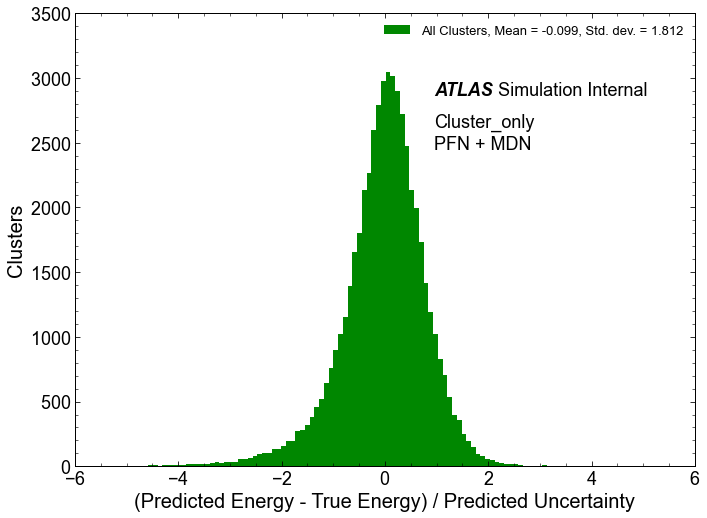

In [46]:
# Plot pull
n_bins = 1000
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pull,bins = n_bins, label='All Clusters, Mean = {:.3f}, Std. dev. = {:.3f}'.format(pull.mean(), pull.std()))
plt.xlabel('(Predicted Energy - True Energy) / Predicted Uncertainty')
plt.ylabel('Clusters')
plt.xlim(-6,6)
plt.legend()

atlas_x = 0.58
atlas_y = 0.85
simulation = True
textlist = [{'x': 0.58, 'y': 0.75, 'text': 'Cluster_only'},
            {'x': 0.58, 'y': 0.7, 'text': 'PFN + MDN'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()